# Notebook for simulation comparisons between batched and sequential Gibbs samplers

In [2]:
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import random
from neal_batched import Neal_batched_Gibbs_sampler
from neal_sequential import Neal_sequential_Gibbs_sampler
# spectral clustering
from sklearn.cluster import SpectralClustering
# import loss
from metrics import loss, greedy_loss, compute_modularity
from utils import warm_initializer

In [3]:
seed = 1
random.seed(seed)

## Small Networks
We simulate on the usual network and compare the speed of convergence while verifying that they converge to the same solution.

## Large Network
Same, simulated data as above, but on larger networks.
We show that the speed goes largely in favour of the batched sampler despite the lack of a proper machine to exploit the at maximum extent the scalability of the batched solution.

## Real Data
We compare the performance on real data.
In particular, we try on mail data from mailEU dataset.


In [4]:
# import the data from the ./data folder, .txt files
data = np.loadtxt('./data/email-Eu-core.txt', dtype=int)
assignments = np.loadtxt('./data/email-Eu-core-department-labels.txt', dtype=int)

# turn data into an adjacency matrix
G = nx.Graph()
G.add_edges_from(data)
A = nx.adjacency_matrix(G).toarray()

z_true = assignments[:,1]

n = A.shape[0]
k = len(np.unique(z_true))

print('Number of nodes:', n)
print('Number of communities:', k)

Number of nodes: 1005
Number of communities: 42


We observe that communities are not balanced:

In [5]:
np.sort(np.bincount(z_true))[::-1]

array([109,  92,  65,  61,  55,  51,  49,  39,  35,  32,  29,  29,  28,
        27,  26,  25,  25,  22,  19,  18,  15,  14,  13,  13,  13,  12,
        10,  10,   9,   9,   8,   8,   6,   6,   5,   4,   4,   3,   3,
         2,   1,   1], dtype=int64)

So it could be possible that the best solution is not provided for 42 communities, but less.
We try to fit the model with different communities and compare the loss.

In [6]:
k_values = np.arange(2, 43)
losses = np.zeros(len(k_values))
modularities = np.zeros(len(k_values))

sc_losses = np.zeros(len(k_values))
sc_modularities = np.zeros(len(k_values))

For small values of k (less than 9) we can compute the proper loss, for higher values we need a greedy implementation that is more computationally feasible (and works as an upper bound of the loss).

We recall that, in our implementation, k is inferred by the initialization. It's enough to provide an initialization using less communities.

In [11]:
n_iter = 500
gamma = 1
ap = 1
bp = 1
aq = 1
bq = 1

In [8]:
# to be changed with salso from R
def majority_vote(z_list, last=50):
    list_tmp = np.array(z_list)
    z_majority = np.zeros(len(z_list[0]))
    for i in range(len(z_list[0])):
        z_majority[i] = np.argmax(np.bincount(list_tmp[-last:,i]))
    return z_majority

In [22]:
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

In [24]:
def salso_estimate(clustering_matrix):
    # clustering matrix: list of clusterings, or array with (n_clusterings, n_nodes)

    # Activate the automatic conversion of numpy objects to R objects
    numpy2ri.activate()

    # Import the salso package
    salso = importr('salso')

    # Convert the numpy matrix to an R matrix
    r_matrix = numpy2ri.py2rpy(np.array(clustering_matrix))

    # Define the R function
    r_code = """
    myfun <- function(mat) {
    library(salso)
    results <- salso(mat, maxZealousAttempts=10000)
    return(as.vector(results))
    }
    """

    # Load the R function into the R environment
    robjects.r(r_code)

    # Get the R function
    r_myfun = robjects.globalenv['myfun']

    # Call the R function with the R matrix
    result = r_myfun(r_matrix)

    # Convert the result back to a numpy array
    return numpy2ri.rpy2py(result)


In [25]:
for k_tmp in k_values:
    np.random.seed(seed)

    print('Number of clusters:', k_tmp)

    sc = SpectralClustering(n_clusters=k_tmp, affinity="precomputed")
    z_init = sc.fit_predict(A)

    if k < 8:
        sc_losses[k_tmp-2] = loss(z_init, z_true)
        print('Initialization Loss:', sc_losses[k_tmp-2])
    else:
        sc_losses[k_tmp-2] = greedy_loss(z_init, z_true)
        print('Initialization Loss:', sc_losses[k_tmp-2])
    sc_modularities[k_tmp-2] = compute_modularity(A, z_init)

    sampler = Neal_batched_Gibbs_sampler(A, z_init, ap, bp, aq, bq, gamma = gamma)
    sampler.run(n_iter)

    # # compute the loss using a majority vote
    # z_majority = majority_vote(sampler.get_z_list())

# we use rpy2 to act find a posterior estimate using the salso algorithm in R
    z_salso = salso_estimate(sampler.get_z_list())

    if k < 8:
        losses[k_tmp-2] = loss(z_salso, z_true)
        print('Batched Loss:', losses[k_tmp-2])
    else:
        losses[k_tmp-2] = greedy_loss(z_salso, z_true)
        print('Batched Loss:', losses[k_tmp-2])
    modularities[k_tmp-2] = compute_modularity(A, z_salso)

Number of clusters: 2


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.808955223880597


 20%|██        | 2/10 [00:00<00:00, 19.99it/s]g:\Il mio Drive\Unito\Tesi\Codice\Tidy\Batched-Gibbs-Sampling-for-Community-Detection-in-SBM\neal_batched.py:154: RuntimeWarning: overflow encountered in exp
  self.pi = pi_pri_mat * np.exp(2 * t * (self.A - lambd_mat).T @ self.Z)
g:\Il mio Drive\Unito\Tesi\Codice\Tidy\Batched-Gibbs-Sampling-for-Community-Detection-in-SBM\neal_batched.py:155: RuntimeWarning: invalid value encountered in divide
  self.pi = self.pi / np.sum(self.pi, axis=1).reshape(-1, 1)
g:\Il mio Drive\Unito\Tesi\Codice\Tidy\Batched-Gibbs-Sampling-for-Community-Detection-in-SBM\neal_batched.py:159: RuntimeWarning: divide by zero encountered in log
  self.z = np.argmax(np.log(self.pi) + rnd.gumbel(size=self.pi.shape), axis=1)
 80%|████████  | 8/10 [00:00<00:00, 19.93it/s]g:\Il mio Drive\Unito\Tesi\Codice\Tidy\Batched-Gibbs-Sampling-for-Community-Detection-in-SBM\neal_batched.py:154: RuntimeWarning: overflow encountered in multiply
  self.pi = pi_pri_mat * np.exp(2 * t * (sel

Batched Loss: 0.83681592039801
Number of clusters: 3
Initialization Loss: 0.8019900497512438


100%|██████████| 10/10 [00:00<00:00, 20.53it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.

c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Batched Loss: 0.8388059701492537
Number of clusters: 4
Initialization Loss: 0.8029850746268656


100%|██████████| 10/10 [00:00<00:00, 20.03it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.

c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Batched Loss: 0.844776119402985
Number of clusters: 5
Initialization Loss: 0.7502487562189055


100%|██████████| 10/10 [00:00<00:00, 17.92it/s]


Batched Loss: 0.7940298507462686
Number of clusters: 6


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.7194029850746269


100%|██████████| 10/10 [00:00<00:00, 19.95it/s]


Batched Loss: 0.7701492537313432
Number of clusters: 7


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.690547263681592


100%|██████████| 10/10 [00:00<00:00, 19.27it/s]


Batched Loss: 0.7393034825870647
Number of clusters: 8


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6915422885572139


100%|██████████| 10/10 [00:00<00:00, 18.68it/s]


Batched Loss: 0.7253731343283583
Number of clusters: 9


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6288557213930348


100%|██████████| 10/10 [00:00<00:00, 20.54it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.

c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Batched Loss: 0.7124378109452736
Number of clusters: 10
Initialization Loss: 0.6149253731343284


100%|██████████| 10/10 [00:00<00:00, 20.69it/s]


Batched Loss: 0.699502487562189
Number of clusters: 11


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.5552238805970149


100%|██████████| 10/10 [00:00<00:00, 21.61it/s]


Batched Loss: 0.6527363184079602
Number of clusters: 12


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6378109452736318


100%|██████████| 10/10 [00:00<00:00, 16.56it/s]


Batched Loss: 0.7124378109452736
Number of clusters: 13


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6149253731343284


100%|██████████| 10/10 [00:00<00:00, 19.10it/s]


Batched Loss: 0.6925373134328359
Number of clusters: 14


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6368159203980099


100%|██████████| 10/10 [00:00<00:00, 20.03it/s]


Batched Loss: 0.7134328358208956
Number of clusters: 15


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6736318407960199


100%|██████████| 10/10 [00:00<00:00, 20.66it/s]


Batched Loss: 0.6975124378109453
Number of clusters: 16


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6606965174129353


100%|██████████| 10/10 [00:00<00:00, 19.55it/s]


Batched Loss: 0.6985074626865672
Number of clusters: 17


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6746268656716418


100%|██████████| 10/10 [00:00<00:00, 18.80it/s]


Batched Loss: 0.7253731343283583
Number of clusters: 18


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.5900497512437811


100%|██████████| 10/10 [00:00<00:00, 20.80it/s]


Batched Loss: 0.6766169154228856
Number of clusters: 19


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6746268656716418


100%|██████████| 10/10 [00:00<00:00, 21.37it/s]


Batched Loss: 0.7054726368159204
Number of clusters: 20


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6298507462686567


100%|██████████| 10/10 [00:00<00:00, 20.93it/s]


Batched Loss: 0.6686567164179105
Number of clusters: 21


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.5462686567164179


100%|██████████| 10/10 [00:00<00:00, 17.36it/s]


Batched Loss: 0.6895522388059702
Number of clusters: 22


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.5144278606965174


100%|██████████| 10/10 [00:00<00:00, 20.10it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.

c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Batched Loss: 0.6547263681592039
Number of clusters: 23
Initialization Loss: 0.564179104477612


100%|██████████| 10/10 [00:00<00:00, 20.68it/s]


Batched Loss: 0.6437810945273632
Number of clusters: 24


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.5661691542288557


100%|██████████| 10/10 [00:00<00:00, 20.74it/s]


Batched Loss: 0.6517412935323383
Number of clusters: 25


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6009950248756218


100%|██████████| 10/10 [00:00<00:00, 21.12it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.

c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Batched Loss: 0.6368159203980099
Number of clusters: 26
Initialization Loss: 0.5402985074626866


100%|██████████| 10/10 [00:00<00:00, 19.96it/s]


Batched Loss: 0.6
Number of clusters: 27


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.5691542288557214


100%|██████████| 10/10 [00:00<00:00, 21.23it/s]


Batched Loss: 0.663681592039801
Number of clusters: 28


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6129353233830845


100%|██████████| 10/10 [00:00<00:00, 21.03it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.

c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Batched Loss: 0.6557213930348259
Number of clusters: 29
Initialization Loss: 0.6666666666666666


100%|██████████| 10/10 [00:00<00:00, 20.74it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.

c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Batched Loss: 0.6358208955223881
Number of clusters: 30
Initialization Loss: 0.6199004975124378


100%|██████████| 10/10 [00:00<00:00, 19.77it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.6935323383084577
Number of clusters: 31


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.5980099502487563


100%|██████████| 10/10 [00:00<00:00, 20.56it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.

c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Batched Loss: 0.6447761194029851
Number of clusters: 32
Initialization Loss: 0.6159203980099502


100%|██████████| 10/10 [00:00<00:00, 15.54it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.6805970149253732
Number of clusters: 33


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6029850746268657


100%|██████████| 10/10 [00:00<00:00, 18.52it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.6109452736318408
Number of clusters: 34


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6527363184079602


100%|██████████| 10/10 [00:00<00:00, 19.42it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.6109452736318408
Number of clusters: 35


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6139303482587065


100%|██████████| 10/10 [00:00<00:00, 19.40it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.6348258706467662
Number of clusters: 36


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.545273631840796


100%|██████████| 10/10 [00:00<00:00, 18.65it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.5930348258706468
Number of clusters: 37


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6537313432835821


100%|██████████| 10/10 [00:00<00:00, 18.84it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.6447761194029851
Number of clusters: 38


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6855721393034826


100%|██████████| 10/10 [00:00<00:00, 16.64it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.7661691542288557
Number of clusters: 39


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6965174129353234


100%|██████████| 10/10 [00:00<00:00, 18.97it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.6388059701492538
Number of clusters: 40


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6527363184079602


100%|██████████| 10/10 [00:00<00:00, 18.21it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.6228855721393035
Number of clusters: 41


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.6039800995024875


100%|██████████| 10/10 [00:00<00:00, 18.55it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.5840796019900497
Number of clusters: 42


c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initialization Loss: 0.7064676616915423


100%|██████████| 10/10 [00:00<00:00, 18.79it/s]
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



Batched Loss: 0.6417910447761194


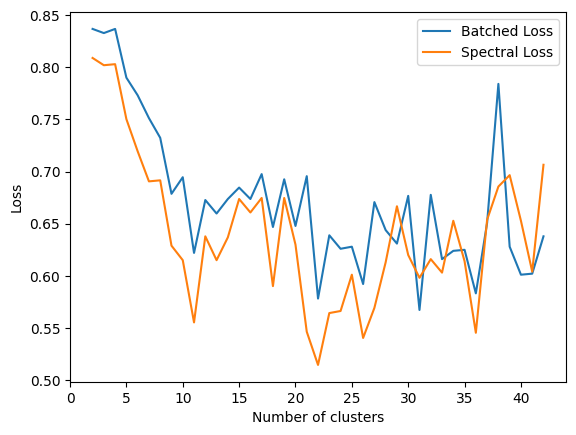

In [13]:
# check modularities and losses for different k
plt.figure()
plt.plot(k_values, losses, label='Batched Loss')
plt.plot(k_values, sc_losses, label='Spectral Loss')
plt.xlabel('Number of clusters')
plt.ylabel('Loss')
plt.legend()
plt.show()


let's use salso

In [14]:
# store on a .csv the results in sampler.get_z_list() in a array version

import pandas as pd
df = pd.DataFrame(sampler.get_z_list())
df.to_csv('./data/results.csv', index=False)

In [21]:


# Activate the automatic conversion of numpy objects to R objects
numpy2ri.activate()

# Import the salso package
salso = importr('salso')

# Convert the numpy matrix to an R matrix
r_matrix = numpy2ri.py2rpy(np.array(sampler.get_z_list()))

# Define the R function
r_code = """
myfun <- function(mat) {
  library(salso)
  results <- salso(mat, maxZealousAttempts=10000)
  return(as.vector(results))
}
"""

# Load the R function into the R environment
robjects.r(r_code)

# Get the R function
r_myfun = robjects.globalenv['myfun']

# Call the R function with the R matrix
result = r_myfun(r_matrix)

# Convert the result back to a numpy array
result_np = numpy2ri.rpy2py(result)

print(result_np)

greedy_loss(result_np, z_true)


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



[1 1 1 ... 4 4 4]


0.6427860696517413

In [ ]:
def salso(example_list):
    numpy2ri.activate()

    # Import the salso package
    salso = importr('salso')

    # Convert the numpy matrix to an R matrix
    r_matrix = numpy2ri.py2rpy(np.array(example_list))

    # Define the R function
    r_code = """
    myfun <- function(mat) {
      library(salso)
      results <- salso(mat, maxZealousAttempts=10000)
      return(as.vector(results))
    }
    """

    # Load the R function into the R environment
    robjects.r(r_code)

    # Get the R function
    r_myfun = robjects.globalenv['myfun']

    # Call the R function with the R matrix
    result = r_myfun(r_matrix)

    # Convert the result back to a numpy array
    result_np = numpy2ri.rpy2py(result)
    
    return result_np

# Mixed Dump

In [ ]:
from tqdm import tqdm
import numpy as np
from utils import one_hot_encode
import numpy.random as rnd
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr


class Neal_batched_Gibbs_sampler():
    """
    A class representing a batched Gibbs sampler for community detection in SBM.

    Parameters:
    - A: numpy array, adjacency matrix of the graph
    - z_0: numpy array, initial community assignment
    - alpha_p_pri: float, prior hyperparameter for alpha_p
    - beta_p_pri: float, prior hyperparameter for beta_p
    - alpha_q_pri: float, prior hyperparameter for alpha_q
    - beta_q_pri: float, prior hyperparameter for beta_q
    - pi_pri: numpy array, prior probability distribution over communities

    Attributes:
    - A: numpy array, adjacency matrix of the graph
    - z: numpy array, current community assignment
    - alpha_p_pri: float, prior hyperparameter for alpha_p
    - beta_p_pri: float, prior hyperparameter for beta_p
    - alpha_q_pri: float, prior hyperparameter for alpha_q
    - beta_q_pri: float, prior hyperparameter for beta_q
    - pi_pri: numpy array, prior probability distribution over communities
    - z_list: list, list of community assignments at each step
    - p_list: list, list of sampled p values at each step
    - q_list: list, list of sampled q values at each step
    - alpha_p: float, posterior hyperparameter for alpha_p
    - beta_p: float, posterior hyperparameter for beta_p
    - alpha_q: float, posterior hyperparameter for alpha_q
    - beta_q: float, posterior hyperparameter for beta_q
    - pi: numpy array, posterior probability distribution over communities
    - p: float, sampled p value
    - q: float, sampled q value
    - n: int, number of nodes in the graph
    - k: int, number of communities
    - Z: numpy array, one-hot encoded community assignment matrix

    Methods:
    - __init__(self, A, z_0, alpha_p_pri, beta_p_pri, alpha_q_pri, beta_q_pri, pi_pri): Initializes the batched Gibbs sampler with the given parameters
    - __beta_updates(self): Updates the posterior hyperparameters alpha_p, beta_p, alpha_q, beta_q, and samples p and q
    - __z_updates(self, append=True): Updates the community assignment z based on the current values of p, q, and pi
    - step(self, append_z=True): Performs one step of the Gibbs sampling algorithm
    - run(self, num_iterations, burn_in=0): Runs the Gibbs sampler for the specified number of iterations
    - get_z_list(self): Returns the list of community assignments at each step
    - get_p_list(self): Returns the list of sampled p values at each step
    - get_q_list(self): Returns the list of sampled q values at each step
    """

    def __init__(self, A, z_0, alpha_p_pri=1, beta_p_pri=1, alpha_q_pri=1, beta_q_pri=1, gamma=None):
        """
        Initializes the batched Gibbs sampler with the given parameters.

        Parameters:
        - A: numpy array, adjacency matrix of the graph
        - z_0: numpy array, initial community assignment
        - alpha_p_pri: float, prior hyperparameter for alpha_p
        - beta_p_pri: float, prior hyperparameter for beta_p
        - alpha_q_pri: float, prior hyperparameter for alpha_q
        - beta_q_pri: float, prior hyperparameter for beta_q
        - pi_pri: numpy array, prior probability distribution over communities
        """
        # data
        self.A = A
        self.z = z_0.copy()

        
        self.n = len(self.z)
        self.k = len(np.unique(self.z))


        # priors
        self.alpha_p_pri = alpha_p_pri
        self.beta_p_pri = beta_p_pri
        self.alpha_q_pri = alpha_q_pri
        self.beta_q_pri = beta_q_pri

        if gamma is None:
            self.gamma = np.ones((self.n, self.k))
        elif isinstance(gamma, (int, float)):
            self.gamma = np.ones((self.n, self.k)) * gamma
        else: 
            gamma = np.array(gamma)
            if gamma.shape == (self.k,):
                self.gamma = np.zeros((self.n, self.k))
                for i in range(self.n):
                    self.gamma[i,:] = gamma
            else:
                assert gamma.shape == (self.n, self.k), "gamma must have shape (n,k), (k,), be None or be a scalar"

        #lists for analyses
        self.z_list = [self.z]
        self.p_list = []
        self.q_list = []


        #posteriors
        self.alpha_p = None
        self.beta_p = None
        self.alpha_q = None
        self.beta_q = None
        self.pi = None

        #sampled
        self.p = None
        self.q = None

        self.Z = one_hot_encode(self.z, self.k)

    def __beta_updates(self):
        """
        Updates the posterior hyperparameters alpha_p, beta_p, alpha_q, beta_q, and samples p and q.
        """
        A_lower = np.tril(self.A)
        cA_lower = np.tril(np.ones((self.n,self.n))) - np.eye(self.n) - A_lower

        U = self.Z.T @ A_lower @ self.Z
        cU = self.Z.T @ cA_lower @ self.Z

        self.alpha_p = self.alpha_p_pri + np.sum(np.diag(U))
        self.beta_p = self.beta_p_pri + np.sum(np.diag(cU))

        # set the diagonal elements to 0
        np.fill_diagonal(U, 0)
        np.fill_diagonal(cU, 0)

        self.alpha_q = self.alpha_q_pri +  np.sum(U)
        self.beta_q = self.beta_q_pri + np.sum(cU)

        self.p = np.random.beta(self.alpha_p, self.beta_p)
        self.q = np.random.beta(self.alpha_q,self.beta_q)
        self.p_list.append(self.p)
        self.q_list.append(self.q)
        return

    def __z_updates(self, append=True):
        """
        Updates the community assignment z based on the current values of p, q, and pi.

        Parameters:
        - append: bool, whether to append the updated community assignment to the z_list
        """
        # compute useful quantities
        t = np.log((self.p * (1-self.q)) / ((1-self.p) * self.q))/2
        lambd = np.log((1-self.q)/(1-self.p)) / (2*t)
        lambd_mat = lambd * ( np.ones((self.n, self.n)) - np.eye(self.n) )

        pi_pri_mat = (np.ones((self.n, self.n)) - np.eye(self.n)) @ self.Z + self.gamma

        # batch update on pi
        self.pi = pi_pri_mat * np.exp(2 * t * (self.A - lambd_mat).T @ self.Z)
        self.pi = self.pi / np.sum(self.pi, axis=1).reshape(-1, 1)

        # sample z from pi
        # using gumbel trick to exploit parallelization
        self.z = np.argmax(np.log(self.pi) + rnd.gumbel(size=self.pi.shape), axis=1)
        #self.z = np.array([np.random.choice(self.k, p=self.pi[i,:]) for i in range(self.n)])
        self.Z = one_hot_encode(self.z, self.k)

        # # added part to handle "collapse" of communities
        # if self.Z.shape[1] != self.k:
        #     print("Community collapse")
        #     self.z[0] = 0
        #     self.z[1] = 1
        #     self.z[2] = 2
        #     self.z[3] = 3
        #     self.Z = one_hot_encode(self.z)

        if append:
            self.z_list.append(self.z.copy())

    def step(self, append_z=True):
        """
        Performs one step of the Gibbs sampling algorithm.

        Parameters:
        - append_z: bool, whether to append the updated community assignment to the z_list
        """
        self.__beta_updates()
        self.__z_updates(append=append_z)
    
    def run(self, num_iterations, burn_in=0):
        """
        Runs the Gibbs sampler for the specified number of iterations.

        Parameters:
        - num_iterations: int, number of iterations to run the Gibbs sampler
        - burn_in: int, number of burn-in iterations to discard from the beginning
        """
        for t in tqdm(range(num_iterations)):
            self.step(append_z=(t >= burn_in))

    def get_z_list(self):
        """
        Returns the list of community assignments at each step.

        Returns:
        - z_list: list, list of community assignments at each step
        """
        return self.z_list
    
    def get_p_list(self):
        """
        Returns the list of sampled p values at each step.

        Returns:
        - p_list: list, list of sampled p values at each step
        """
        return self.p_list
    
    def get_q_list(self):
        """
        Returns the list of sampled q values at each step.

        Returns:
        - q_list: list, list of sampled q values at each step
        """
        return self.q_list
    
    def partition_point_estimate(self, num_iterations, num_chains=2, num_splits=4, lower_bound = 0.9, upper_bound = 1.1, quantity ="p"):
        """
        Runs the chain, finds the convergence iterations, and passes one of the list of z samples,
        from convergence to the end of the iterations, to a function called "salso".

        Parameters:
        - num_iterations: int, number of iterations to run the Gibbs sampler
        - num_chains: int, number of chains to run
        - num_splits: int, number of splits for R_hat computation
        """
        z_samples = []
        samples = []
        
        # Run the Gibbs sampler for the specified number of iterations and chains
        for _ in range(num_chains):
            self.run(num_iterations)
            z_samples.append(self.get_z_list())
            if quantity == "p":
                samples.append(self.get_p_list())
            elif quantity == "q":
                samples.append(self.get_q_list())
            else:
                raise ValueError("Quantity must be either 'p' or 'q'")

        # Compute the R_hat values to find the convergence iteration
        R_hat_list = progressive_R_hat(samples, splits=num_splits, n_chains=num_chains, n_iter=num_iterations)
        convergence_iter = find_convergence(R_hat_list, lb=lower_bound, ub=upper_bound)  # Assuming convergence bounds between 1.0 and 1.1

        if convergence_iter == -1:
            raise ValueError("Convergence not achieved within the specified iterations")

        # Extract the z samples from the convergence iteration to the end
        # take only samples after convergence
        z_samples_post_convergence = [z_list[convergence_iter:] for z_list in z_samples]
        # now, this it list of lists, we need to flatten it
        z_samples_post_convergence = [item for sublist in z_samples_post_convergence for item in sublist]

        # Pass the z samples to the "salso" function
        result = self._salso(z_samples_post_convergence)
        return result
    
    def _salso(self, example_list):
        numpy2ri.activate()

        # Import the salso package
        salso = importr('salso')

        # Convert the numpy matrix to an R matrix
        r_matrix = numpy2ri.py2rpy(np.array(example_list))

        # Define the R function
        r_code = """
        myfun <- function(mat) {
        library(salso)
        results <- salso(mat, maxZealousAttempts=10000)
        return(as.vector(results))
        }
        """

        # Load the R function into the R environment
        robjects.r(r_code)

        # Get the R function
        r_myfun = robjects.globalenv['myfun']

        # Call the R function with the R matrix
        result = r_myfun(r_matrix)

        # Convert the result back to a numpy array
        result_np = numpy2ri.rpy2py(result)
        
        return result_np




def split_chains(chains, splits = 2):
    # chains is a list of arrays
    n_tot = len(chains[0])
    if n_tot % splits != 0:
        raise ValueError("The number of samples is not divisible by the number of splits")
    # split each chain into splits parts
    split_chains = []
    for chain in chains:
        split_chain = np.array_split(chain, splits)
        split_chains.append(split_chain)
    return np.vstack(split_chains).T # row index: iteration, col_index: chain

def R_hat(split_chains):
    n = split_chains.shape[0]
    m = split_chains.shape[1]

    # Verifica che ci siano abbastanza campioni per il calcolo
    if n <= 1:
        raise ValueError(f"Insufficient number of iterations per split ({n}). Increase the number of iterations or reduce the number of splits.")

    # within chains variance
    W = np.mean(np.sum((split_chains - np.mean(split_chains, axis=0))**2, axis=0)/(n-1))
    # between chains variance
    B = n * np.sum((np.mean(split_chains, axis=0) - np.mean(split_chains))**2) / (m-1)
    # estimated variance
    var_plus = (n-1)/n * W + 1/n * B

    return np.sqrt(var_plus/W)


def progressive_R_hat(estimand_array, splits=2, n_chains=4, n_iter=250, burn_in=0, ignore=0):
    """
    Compute the progressive R_hat statistic over a series of iterations, checking
    for convergence as more samples are added.

    Args:
        estimand_array (ndarray): 2D array of shape (iterations, chains) containing samples.
        splits (int): Number of splits for each chain to compute R_hat. Defaults to 2.
        n_chains (int): Number of chains in the estimand_array. Defaults to 4.
        n_iter (int): Total number of iterations (rows) in the estimand_array.
        burn_in (int): Number of initial iterations to discard. Defaults to 0.
        ignore (int): Proportion of samples to ignore. Defaults to 0.

    Returns:
        R_hat_list (ndarray): Array of R_hat values computed for different segments.
    """

    # Allocate space for the R_hat values (indices divided by `splits`)
    R_hat_list = np.zeros((n_iter-burn_in)//splits)

    if not isinstance(estimand_array, np.ndarray):
        estimand_array = np.array(estimand_array).T

    # Iterate through the rows, taking steps of `splits`
    for r in range(1+splits, n_iter-burn_in, splits):
        l = int(r*ignore)  # Compute the initial index to ignore a portion of the samples
        # Adjust `l` to ensure (r+1-l) is a multiple of `splits`
        while ((r+1-l) % splits) or (l!=0) != 0:
            l -= 1

        # Extract the first `r+1` rows, while possibly ignoring some samples
        list_split = estimand_array[l:r+1, :]
        # Convert the 2D array into a list of arrays (one for each chain)
        list_split = [list_split[:, i] for i in range(n_chains)]
        # Split the chains into `splits` segments
        list_split = split_chains(list_split, splits)

        # Calculate and store R_hat
        R_hat_list[r//splits] = R_hat(list_split)

    return R_hat_list


def find_convergence(list, lb, ub):
    candidates = []
    for i in range(len(list)):
        if list[i] > lb and list[i] < ub:
            candidates.append(i)
    for i in candidates:
        # check if all the following values are within the bounds
        if all([list[j] > lb and list[j] < ub for j in range(i+1, len(list))]):
            return i
    return -1

# instance of the class
batched_sampler = Neal_batched_Gibbs_sampler(adj_matrix, z_init_small, alpha_p, beta_p, alpha_q, beta_q, gamma)
# run the function
result = batched_sampler.partition_point_estimate(100, num_chains=2, num_splits=4, lower_bound = 0.9, upper_bound = 1.1, quantity ="p")

# compute loss
from metrics import loss
loss(result, z_true_small)